# Proyecto: Predicción de Alzheimer a partir de MRI usando Deep Learning




## **0. Integrantes del equipo de trabajo**
---
1. RAÚL RAMÍREZ PENAGOS
2. IVÁN QUEVEDO
3. LINA ÁVILA MORENO

## **1. Entendimiento de los datos**

El conjunto de datos contiene 4 clases y etiquetas del 0 al 3:

1. Non demented : '0'
2. Very midly demented : '1'
3. Mildly demented : '2'
4. Moderately demented : '3'

In [ ]:
#pip install opencv-python
#!pip install tensorflow

In [ ]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import hashlib
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import random
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau



In [ ]:
#!pip install pyarrow

In [ ]:
etiqueta_enfermedad_categoria = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [ ]:
def decodificar_imagen(image_dict):
    if isinstance(image_dict, dict) and "bytes" in image_dict:
        byte_string = image_dict["bytes"]
        datos_raw_np = np.frombuffer(byte_string, np.uint8)

        # Cargar en escala de grises (1 canal)
        img = cv2.imdecode(datos_raw_np, cv2.IMREAD_GRAYSCALE)

        # Redimensionar
        img = cv2.resize(img, (224, 224))

        # Expandir a 3 canales se replicó la imagen en gris
        img_3ch = np.stack([img, img, img], axis=-1)

        return img_3ch

    else:
        raise TypeError(f"Se esperaba un diccionario {type(image_dict)}")

## **2. Modelo**

In [ ]:
def oversample(X, y):
    X_bal = list(X)
    y_bal = list(y)

    values, counts = np.unique(y, return_counts=True)
    max_count = counts.max()

    for cls, count in zip(values, counts):
        if count < max_count:
            deficit = max_count - count
            indices = np.where(y == cls)[0]
            sampled_idx = np.random.choice(indices, deficit, replace=True)

            X_bal.extend(X[sampled_idx])
            y_bal.extend(y[sampled_idx])

    return np.array(X_bal), np.array(y_bal)

X = np.stack(df_train['img_arr'].values)
y = df_train['label'].values

X_bal, y_bal = oversample(X, y)

print("Dataset balanceado:", np.bincount(y_bal))


Dataset balanceado: [2566 2566 2566 2566]


In [ ]:
#Partición del conjunto de datos

X_train, X_temp, y_train, y_temp = train_test_split(
    X_bal, y_bal, test_size=0.25, stratify=y_bal, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(np.bincount(y_train), np.bincount(y_val), np.bincount(y_test))

[1924 1925 1924 1925] [321 320 321 321] [321 321 321 320]


In [ ]:
train_datagen = ImageDataGenerator(
    zoom_range=0.02,
    rotation_range=2,
    brightness_range=[0.9, 1.1],
    preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

batch_size = 32

train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_gen   = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)


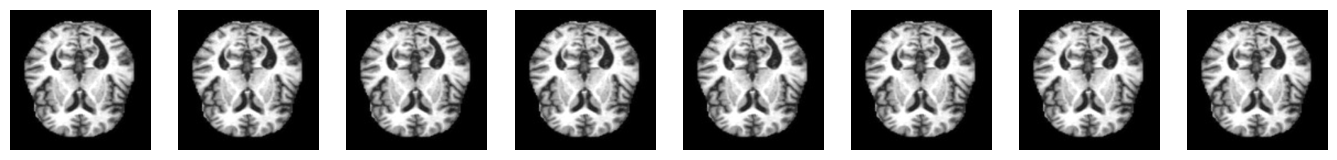

In [ ]:
def normalize_mri_for_display(img):
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip(img, p2, p98)
    img = (img - img.min()) / (img.max() - img.min() + 1e-10)
    return img
random_index = random.randint(0, len(df_train) - 1)

image_data = df_train.loc[random_index, 'img_arr']  # (H,W,1)

x = image_data.reshape((1,) + image_data.shape)

fig, axs = plt.subplots(1, 8, figsize=(17, 4))

i = 0
for batch in ImageDataGenerator().flow(x, batch_size=1):
    img = batch[0][:,:,0]

    # ⚡ Normalizamos SOLO para visualización
    img_norm = normalize_mri_for_display(img)

    axs[i].imshow(img_norm, cmap='gray')
    axs[i].axis('off')

    i += 1
    if i == 8:
        break

plt.show()



In [ ]:
#verificando dimensiones
print(df_train['img_arr'].iloc[0].shape)


(224, 224, 3)


In [ ]:
unique, counts = np.unique(y_bal, return_counts=True)
print(dict(zip(unique, counts)))

{0: 2566, 1: 2566, 2: 2566, 3: 2566}


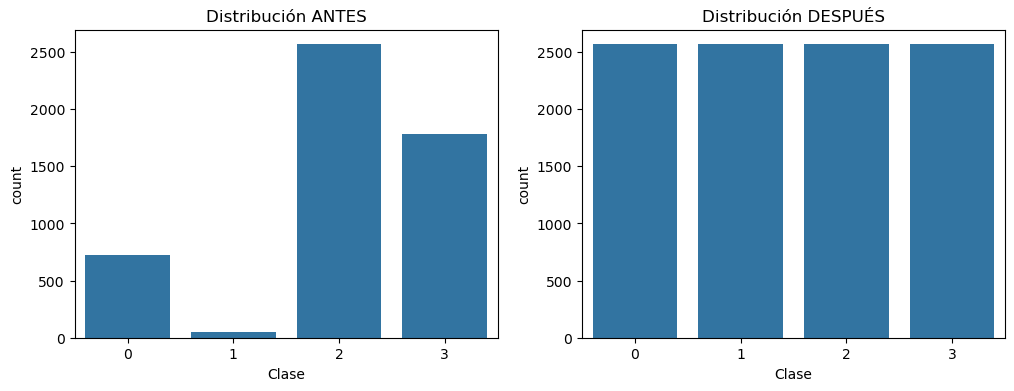

In [ ]:
# Dataframes para graficar
df_before = pd.DataFrame({"Clase": y})
df_after  = pd.DataFrame({"Clase": y_bal})

fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.countplot(data=df_before, x="Clase", ax=ax[0])
ax[0].set_title("Distribución ANTES")

sns.countplot(data=df_after, x="Clase", ax=ax[1])
ax[1].set_title("Distribución DESPUÉS")

plt.show()

In [ ]:
#Generadores

from tensorflow.keras.applications.vgg16 import preprocess_input

# Generador de entrenamiento
train_datagen = ImageDataGenerator(
    zoom_range=0.02,
    rotation_range=2,
    brightness_range=[0.9, 1.1],
    preprocessing_function=preprocess_input
)

# Generador validación
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


In [ ]:
batch_size = 32

train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_gen   = val_datagen.flow(X_val, y_val, batch_size=batch_size, shuffle=False)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

input_shape = (224, 224, 3)
num_classes = 4

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


2025-12-04 17:12:22.969596: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-04 17:12:22.970526: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M3 Pro


In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

ruta_pesos = "pesos_del_modelo.weights.h5"

checkpoint = ModelCheckpoint(
    filepath=ruta_pesos,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

plateau = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    factor=0.5
)


In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=12,
    callbacks=[checkpoint, plateau],
    verbose=1
)


Epoch 1/12


2025-12-04 17:12:59.707200: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2025-12-04 17:13:00.287677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


241/241 [==============================] - ETA: 0s - loss: 1.2005 - accuracy: 0.5444

2025-12-04 17:13:45.115148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.78668, saving model to pesos_del_modelo.weights.h5
241/241 [==============================] - 48s 191ms/step - loss: 1.2005 - accuracy: 0.5444 - val_loss: 0.7867 - val_accuracy: 0.7467 - lr: 1.0000e-04
Epoch 2/12
241/241 [==============================] - ETA: 0s - loss: 0.7042 - accuracy: 0.6877
Epoch 2: val_loss improved from 0.78668 to 0.55760, saving model to pesos_del_modelo.weights.h5
241/241 [==============================] - 44s 181ms/step - loss: 0.7042 - accuracy: 0.6877 - val_loss: 0.5576 - val_accuracy: 0.7786 - lr: 1.0000e-04
Epoch 3/12
241/241 [==============================] - ETA: 0s - loss: 0.5745 - accuracy: 0.7407
Epoch 3: val_loss improved from 0.55760 to 0.48945, saving model to pesos_del_modelo.weights.h5
241/241 [==============================] - 44s 181ms/step - loss: 0.5745 - accuracy: 0.7407 - val_loss: 0.4895 - val_accuracy: 0.7927 - lr: 1.0000e-04
Epoch 4/12
241/241 [==============================] - ETA: 0s - loss: 

In [ ]:
#evaluación contra test
test_gen = val_datagen.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

test_loss, test_acc = model.evaluate(test_gen)
print("Accuracy en test:", test_acc)


41/41 [==============================] - 2s 53ms/step - loss: 0.0704 - accuracy: 0.9680
Accuracy en test: 0.9680436253547668


In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

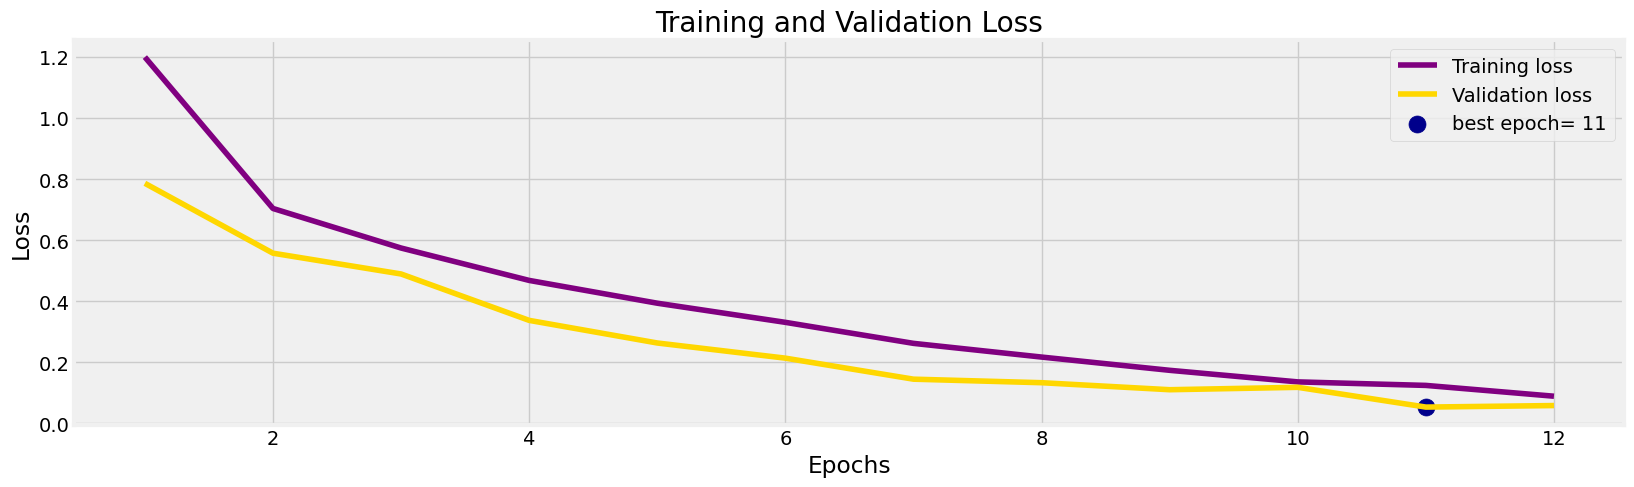

In [ ]:
plt.figure(figsize= (20, 5))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
plt.show()

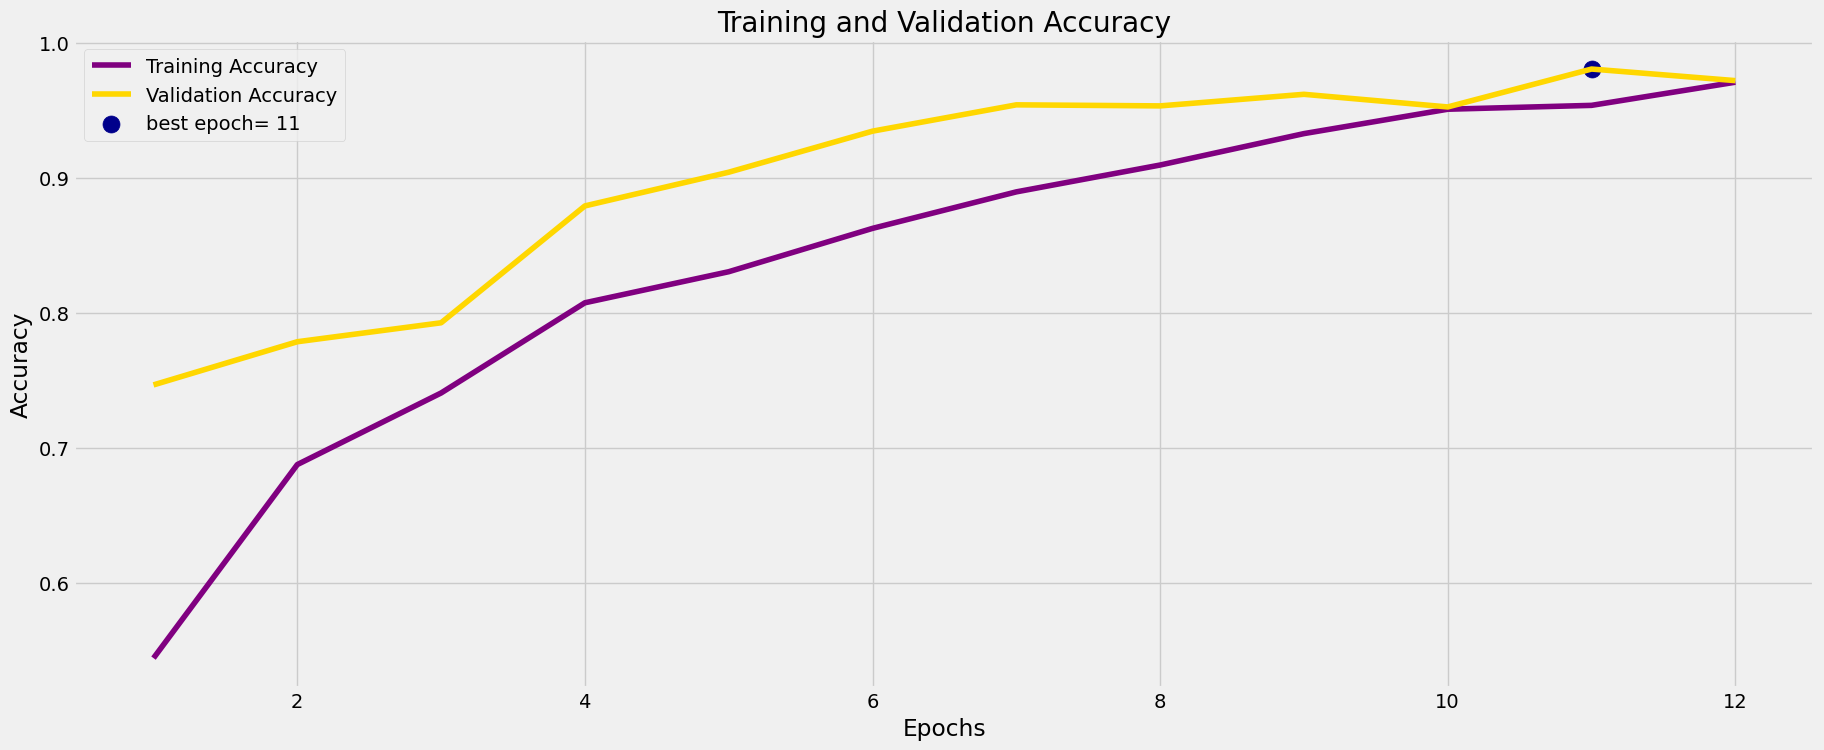

In [ ]:
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
y_pred_prob = model.predict(val_gen)
y_pred = np.argmax(y_pred_prob, axis=1)


 2/41 [>.............................] - ETA: 2s

2025-12-04 17:31:03.201942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 2s 45ms/step
